### Object Detection Model Using FasterRCNN Model

#### Detect Crown-Of-Thorns Starfish in the Great Barrier Reef


*References:*
1. you359. (n.d.). You359/Keras-FASTERRCNN: Keras implementation of faster R-CNN. GitHub.https://github.com/you359/Keras-FasterRCNN
2. https://www.kaggle.com/code/geyiming/faster-rcnn-model

In [4]:
# Import all required libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from PIL import Image
from tqdm import tqdm
from collections import defaultdict
import ast
from matplotlib import pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
import torchvision
import torch.nn as nn
from torchmetrics.metric import Metric
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN


In [7]:
!pip install -q --upgrade wandb

# Login 
import wandb
print(wandb.__version__)
wandb.login(anonymous='must')

wandb: Currently logged in as: anony-moose-458231. Use `wandb login --relogin` to force relogin


0.13.6


True

**Read the dataset from google drive**

In [13]:
# access data from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
df = pd.read_csv('/content/gdrive/MyDrive/DeepLearning/train_new.csv')

# check if the annotations label is of a valid datatype and turn annotations from strings into lists of dictionary
tqdm.pandas()
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))

# print data
df.head()

100%|██████████| 98/98 [00:00<00:00, 15157.53it/s]


,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]


Create new variable to find the image path


In [24]:
# create new variable
df['num_bounding_box'] = df['annotations'].progress_apply(lambda x: len(x))
df.head()

100%|██████████| 98/98 [00:00<00:00, 32160.38it/s]


,video_id,sequence,video_frame,sequence_frame,image_id,annotations,num_bounding_box
0,0,40258,0,0,0-0,[],0
1,0,40258,1,1,0-1,[],0
2,0,40258,2,2,0-2,[],0
3,0,40258,3,3,0-3,[],0
4,0,40258,4,4,0-4,[],0


Filter only the columns where number of bounding boxes is greater than 0

In [25]:
# filter only the columns
df = df[df["num_bounding_box"]>0].reset_index(drop=True)
df.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,num_bounding_box
0,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",1
1,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",1
2,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",1
3,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",1
4,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",1


Add new variable for image Path

In [26]:
# Add new variable for image Path
df['imagePath'] = "video_" + df['video_id'].astype(str) + "/" + df['video_frame'].astype(str) + ".jpg"
df.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,num_bounding_box,imagePath
0,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",1,video_0/16.jpg
1,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",1,video_0/17.jpg
2,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",1,video_0/18.jpg
3,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",1,video_0/19.jpg
4,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",1,video_0/20.jpg


Add new box dimension column

In [27]:
# create a function to find bpunding box dimensions
def find_box_dimensions(annotations):
    bounding_box = [list(annot.values()) for annot in annotations]
    return bounding_box

# create new column for bounding box dimensions
df['box_location_label'] = df.annotations.progress_apply(find_box_dimensions)
df.sample(5)

100%|██████████| 82/82 [00:00<00:00, 9483.88it/s]


,video_id,sequence,video_frame,sequence_frame,image_id,annotations,num_bounding_box,imagePath,box_location_label
68,0,40258,84,84,0-84,"[{'x': 375, 'y': 366, 'width': 75, 'height': 69}]",1,video_0/84.jpg,"[[375, 366, 75, 69]]"
41,0,40258,57,57,0-57,"[{'x': 539, 'y': 362, 'width': 116, 'height': ...",2,video_0/57.jpg,"[[539, 362, 116, 106], [662, 566, 101, 78]]"
79,0,40258,95,95,0-95,"[{'x': 308, 'y': 540, 'width': 100, 'height': ...",1,video_0/95.jpg,"[[308, 540, 100, 81]]"
57,0,40258,73,73,0-73,"[{'x': 429, 'y': 182, 'width': 57, 'height': 57}]",1,video_0/73.jpg,"[[429, 182, 57, 57]]"
15,0,40258,31,31,0-31,"[{'x': 518, 'y': 171, 'width': 71, 'height': 55}]",1,video_0/31.jpg,"[[518, 171, 71, 55]]"


**Train-Test Split of Dataset**

In [28]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(df, test_size=0.2, random_state=53)

print("Train dataset shape = ",train.shape)
print("validation dataset shape = ",validation.shape)

Train dataset shape =  (65, 9)
validation dataset shape =  (17, 9)


In [29]:
# define the path and some values 
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_EPOCHS = 3

class COTSDataset:
    
    
    # define initialization function
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        
    
    def apply_augmentation(self, boxes):
        """ 
        The menthods check for bounding boxes augmentation. Check for image boundaries to male sure the augmentation
        can be applied.
        """
        out_of_box_image = ((boxes[:, 0] < 0).any() or (boxes[:, 1] < 0).any() 
                             or (boxes[:, 2] > 1280).any() or (boxes[:, 3] > 720).any())
        return not out_of_box_image
    
    
    def get_box_dimensions(self, row):
        """Returns the bboxes for a given row as a 3D matrix with format [x_min, y_min, x_max, y_max]"""
        boxes = pd.DataFrame(row['annotations'], columns=['x', 'y', 'width', 'height']).astype(np.float32).values
        
        # Change from [x_min, y_min, w, h] to [x_min, y_min, x_max, y_max]
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return boxes
    
    def find_image(self, row):
        """Gets the image for a given row"""
        
        image = cv2.imread(f'{BASE_DIR}/{row["imagePath"]}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        return image
    
    
    def __getitem__(self, i):

        row = self.df.iloc[i]
        image = self.find_image(row)
        boxes = self.get_box_dimensions(row)
        
        n_boxes = boxes.shape[0]
        
        # Calculate the area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'area': torch.as_tensor(area, dtype=torch.float32),
            
            'image_id': torch.tensor([i]),
            
            # There is only one class
            'labels': torch.ones((n_boxes,), dtype=torch.int64),
            
            'iscrowd': torch.zeros((n_boxes,), dtype=torch.int64)
                        
        }

        if self.transforms and self.apply_augmentation(boxes):
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            if n_boxes > 0:
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        else:
            image = ToTensorV2(p=1.0)(image=image)['image']

        return image, target

    def __len__(self):
        return len(self.df)

In [30]:
# define functions for data transformation
def train_transform():
    return A.Compose([A.Flip(0.5),
                       ToTensorV2(p=1.0)
                      ], bbox_params={'format': 'pascal_voc','label_fields': ['labels']})

def validation_transform():
    return A.Compose([
                       ToTensorV2(p=1.0)
                      ], bbox_params={'format': 'pascal_voc','label_fields': ['labels']})


train_dataset = COTSDataset(train, train_transform())
validation_dataset = COTSDataset(validation, validation_transform())

In [31]:
# Collate function
def collate_fn(batch):
    return tuple(zip(*batch))

**Create PyTorch DataLoader**

In [32]:
BATCH_SIZE = 5
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,  
                          collate_fn=collate_fn)
validation_loader = DataLoader(validation_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,  
                          collate_fn=collate_fn)

**Test one sample**

torch.Size([3, 720, 1280])
dict_keys(['boxes', 'area', 'image_id', 'labels', 'iscrowd'])
tensor([[520.0000, 507.0000, 598.0000, 569.0000],
        [598.0000, 484.0000, 656.0000, 516.0000]], dtype=torch.float64)
tensor([2])


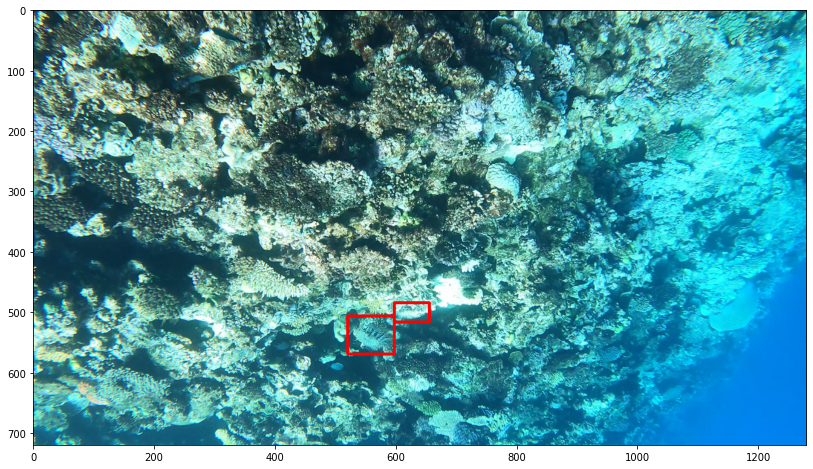

In [33]:
num_bounding_boxes = 0
attempts = 10
while (num_bounding_boxes == 0):
    images, labels = next(iter(train_loader))
    
    # images and labels list datatype
    idx = np.random.randint(0, BATCH_SIZE)
    img = images[idx]
    target = labels[idx]
    num_bounding_boxes = len(target['boxes'])
    attempts -= 1
    if attempts == 0:
        break

if num_bounding_boxes > 0:        
    print(img.shape)
    print(target.keys())
    print(target['boxes'])

    img = img.permute(1,2,0).numpy()
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    if num_bounding_boxes > 0:
        boxes = target['boxes'].numpy()
        for box in boxes:
            c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
            cv2.rectangle(img, c1, c2,
                      (220, 0, 0), 3)

    plt.title(print(target['image_id']))
    plt.imshow(img)
    plt.show()
else:
    print('Failed')

**Create the model**

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Use pretrained resnet50 model  
# load the model which is pre-trained on COCO dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model = model.to(device)

# define number of classes ( two classes as there can be starfish and background)
num_classes = 2 

# find number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes).to(device)

**Test the model on sample data**

In [ ]:
images = list(image.to(device) for image in images)
labels = [{k: v.long().to(device) for k, v in t.items()} for t in labels]
loss_dict = model(images, labels)
losses = sum(loss for loss in loss_dict.values())
loss = losses.item()
loss

1.2029753923416138

**Train the model**

In [ ]:
# define variables
total_train_loss = []
total_validation_loss = []
losses_value = 0
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001)
lr_scheduler = None
num_epochs = 3

for epoch in range(num_epochs):
    
    start_time = time.time()
    
    # for train data
    train_loss = []
    for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
        
        images = list(image.to(device) for image in images)
        labels = [{k: v.long().to(device) for k, v in t.items()} for t in labels]
              
        loss_dict = model(images, labels)
        
        losses = sum(loss for loss in loss_dict.values())
        losses_value = losses.item()
        
        train_loss.append(losses_value)   

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
            
    if lr_scheduler is not None:
        lr_scheduler.step()
        
        
    # for validation dataset
    with torch.no_grad():
        validation_loss = []
        for batch_idx,(images, labels) in enumerate(validation_loader,1):
            images = list(image.to(device) for image in images)
            labels = [{k: v.long().to(device) for k, v in t.items()} for t in labels]
            
            loss_dict = model(images, labels)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            validation_loss.append(loss_value)
    
    epoch_validation_loss = np.mean(validation_loss)           
    total_validation_loss.append(epoch_validation_loss)
    
    chk_name = f'fasterrcnn_resnet50_fpn-e{epoch+1}.bin'
    torch.save(model.state_dict(), chk_name)
    
    print(f"Epoch Completed: {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}, valid Loss: {epoch_validation_loss} --> {chk_name}")

100%|██████████| 9/9 [25:59<00:00, 173.28s/it]


Epoch Completed: 1/3, Train Loss: 0.44719351331392926, Valid Loss: 0.25110209981600445 --> fasterrcnn_resnet50_fpn-e1.bin


100%|██████████| 9/9 [25:03<00:00, 167.04s/it]


Epoch Completed: 2/3, Train Loss: 0.2282552719116211, Valid Loss: 0.1947841097911199 --> fasterrcnn_resnet50_fpn-e2.bin


100%|██████████| 9/9 [25:01<00:00, 166.82s/it]


Epoch Completed: 3/3, Train Loss: 0.20158442854881287, Valid Loss: 0.17327865461508432 --> fasterrcnn_resnet50_fpn-e3.bin


**Plot Training and Validation Loss**

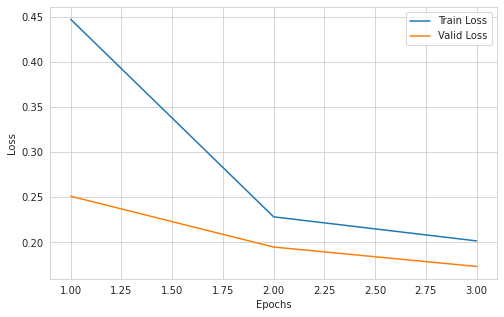

In [ ]:
plt.figure(figsize=(8, 5))
sns.set_style(style="whitegrid")
sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_validation_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
# describe model
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(